# Design Pattern 5: Reframing

> Refere-se à alteração da representação do resultado de um problema de aprendizado de máquina. Isso pode envolver a mudança da natureza do problema de uma tarefa de regressão para uma de classificação, e vice-versa

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

### Base de exemplo

In [2]:
df = pd.read_csv('data/babyweight_train.csv')
df.dropna(inplace=True)
print(df.shape)
df.head()

(185665, 6)


,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
0,7.749249,False,12,Single(1),40,1.0
1,7.561856,True,12,Single(1),40,2.0
2,7.187070,False,12,Single(1),34,3.0
3,6.375769,True,12,Single(1),36,2.0
5,6.000983,False,12,Single(1),39,2.0


### Design Pattern 5: Reframing

- Avalie se reframing (mudar a forma como você aborda o problema) pode ser benéfico para lidar com a incerteza ou a variação
- Se decidir por reframing, escolha uma abordagem específica
- Modifique a formulação do problema para incorporar a nova abordagem

> Nesse exemplo, queremos prever o peso de um recém-nascido em libras (regressão) e podemos usar o padrão de reframing devido a natureza probabilística inerente ao problema, porque a distribuição dos pesos dos bebês apresenta uma considerável dispersão em relação à média.

/tmp/ipykernel_18298/2945180310.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['weight_pounds'], kde=True, color='#191970')


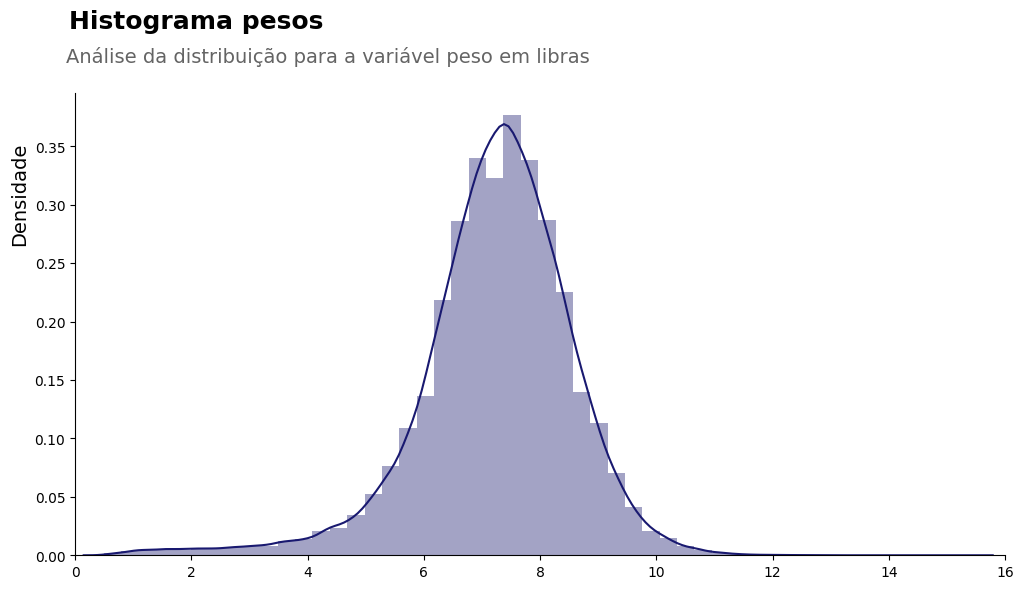

In [3]:
suptitle = 'Histograma pesos'
title = 'Análise da distribuição para a variável peso em libras'

ax = sns.distplot(df['weight_pounds'], kde=True, color='#191970')
ax.figure.set_size_inches(12, 6)
ax.set_ylabel('Densidade', fontsize=14, horizontalalignment='left', y=0.67)
ax.set_xlabel(None)
ax.spines[['top', 'right']].set_visible(False)
plt.suptitle(suptitle, fontsize=18, y=1.02, horizontalalignment='left', x=0.12, color='black', weight='bold')
plt.title(title, fontsize=14, color='#646464', y=1.05, loc='left', x=-0.01)
plt.xlim(0, 16)
plt.grid(False)
plt.show()

#### Discretiza a variável de destino 'weight_pounds' para que o problema seja tratado como classificação

In [4]:
bins = [0, 6.5, 7.5, 8.5, np.inf]
labels = [0, 1, 2, 3]
df['weight_category'] = pd.cut(df['weight_pounds'], bins=bins, labels=labels, right=False)

#### Prepara os dados

In [5]:
X = df.drop(['weight_pounds', 'weight_category'], axis=1)
y = df['weight_category']

#### Divide a base

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Treino

In [7]:
model = Pipeline([
    ('preprocess', ColumnTransformer(transformers=[('plurality', OneHotEncoder(), ['plurality'])], remainder='passthrough')),
    ('clf', CalibratedClassifierCV(DecisionTreeClassifier(), method='isotonic', cv=5))
])

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)

In [8]:
sex = 'masculino' if X_test[:1]['is_male'].values[0] else 'feminino'
plurality = X_test[:1]['plurality'].values[0]
weeks = X_test[:1]['gestation_weeks'].values[0]
age = X_test[:1]['mother_age'].values[0]

print(f'Primeiro exemplo de teste é sobre um bebê {plurality} do sexo {sex} nascido com {weeks} semanas de uma mãe de {age} anos.\n')
print(f'Probabilidade: {y_prob[0]}\n')

max_prob = round(y_prob[0].max() * 100, 2)
idx_max = np.argmax(y_prob[0])
limit_inf = bins[idx_max]
limit_sup = bins[idx_max + 1] if idx_max + 1 < len(bins) else np.inf

print(f'Isso significa que o peso do bebê tem {max_prob}% de chances de estar na categoria {idx_max} que compreende os pesos entre {limit_inf} e {limit_sup} libras.')

Primeiro exemplo de teste é sobre um bebê Single(1) do sexo masculino nascido com 39 semanas de uma mãe de 25 anos.

Probabilidade: [0.11329551 0.30928899 0.38707756 0.19033794]

Isso significa que o peso do bebê tem 38.71% de chances de estar na categoria 2 que compreende os pesos entre 7.5 e 8.5 libras.
